# the task: predict next months closing prices for stocks

**Things to think about:**

data cleaning/transformation

feature selection

model selection


amount/type of data

Marks:

1 mark for code quality

2 marks for results

2 marks for method

** Come to our AGM!**

In [0]:
!pip install quandl
!pip install matplotlib
!pip install pandas
!pip install sklearn
!pip install numpy
!pip install keras

     |████████████████████████████████| 61kB 7.7MB/s 
     |████████████████████████████████| 61kB 20.6MB/s 
     |████████████████████████████████| 2.3MB 14.2MB/s 
     |████████████████████████████████| 102kB 26.8MB/s 
  Created wheel for inflection: filename=inflection-0.3.1-cp36-none-any.whl size=6076 sha256=dd1bf7244988b2c09c15b044cf0985d7118c0d14e61c0d2684df17c729ce2ab3
  Stored in directory: /root/.cache/pip/wheels/9f/5a/d3/6fc3bf6516d2a3eb7e18f9f28b472110b59325f3f258fe9211
Successfully built inflection
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: more-itertools 7.2.0
    Uninstalling more-itertools-7.2.0:
      Successfully uninstalled more-itertools-7.2.0


In [0]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import quandl
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.decomposition import PCA
import keras
#import everything we'll use

Using TensorFlow backend.


In [0]:
quandl.ApiConfig.api_key = "YourAPIKEYHERE"
#get our data
#feel free to get more but these are the dates i'll be testing
apple_data = quandl.get("WIKI/AAPL", start_date="2006-2-01", end_date="2006-8-01")
papple_data = quandl.get("WIKI/AAPL", start_date="2006-8-01", end_date="2006-8-30")
amanoz_data = quandl.get("WIKI/AMZN", start_date="2006-2-01", end_date="2006-8-01") 
pamanoz_data = quandl.get("WIKI/AMZN", start_date="2006-8-01", end_date="2006-8-30")
monster_data = quandl.get("WIKI/MNST", start_date="2006-2-01", end_date="2006-8-01")
pmonster_data = quandl.get("WIKI/MNST", start_date="2006-8-01", end_date="2006-8-30")

In [0]:
print(np.array(apple_data["Close"]).shape)
print(np.array(papple_data["Close"]).shape)
#these are the amount of points in the data

(126,)
(22,)


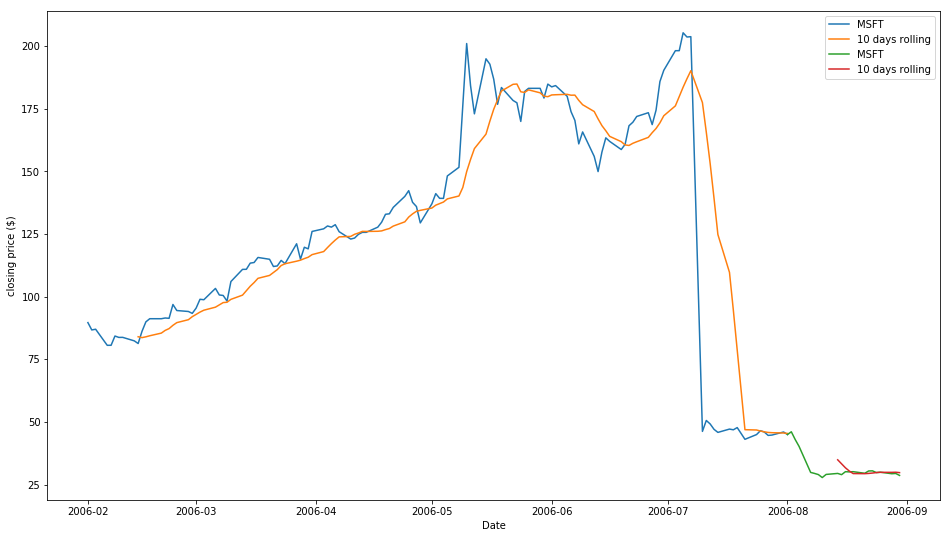

In [0]:
def plot_rolling_mean(dataframe,start,end,fig=None,ax=None):
  #select closing prices
  close = dataframe["Close"]
  all_weekdays = pd.date_range(start=start, end=end, freq='B')
  #index the dataframe to get all values
  close = close.reindex(all_weekdays)
  close = close.fillna(method="ffill")

  # Calculate the 20 days moving averages of the closing prices
  short_rolling_msft = close.rolling(window=10).mean()

  #figure out if we need to create an axis to plot it on
  if not fig:
    fig, ax = plt.subplots(figsize=(16,9))
    
  #plot the data vs the dates
  ax.plot(close.index, close, label='MSFT')
  ax.plot(short_rolling_msft.index, short_rolling_msft, label="10 days rolling")

  ax.set_xlabel('Date')
  ax.set_ylabel('closing price ($)')
  ax.legend()
  return fig,ax

#example use
fig,ax = plot_rolling_mean(monster_data,"2006-2-01","2006-8-01")
fig,ax = plot_rolling_mean(pmonster_data,"2006-8-01","2006-8-30",fig,ax)
fig.show()

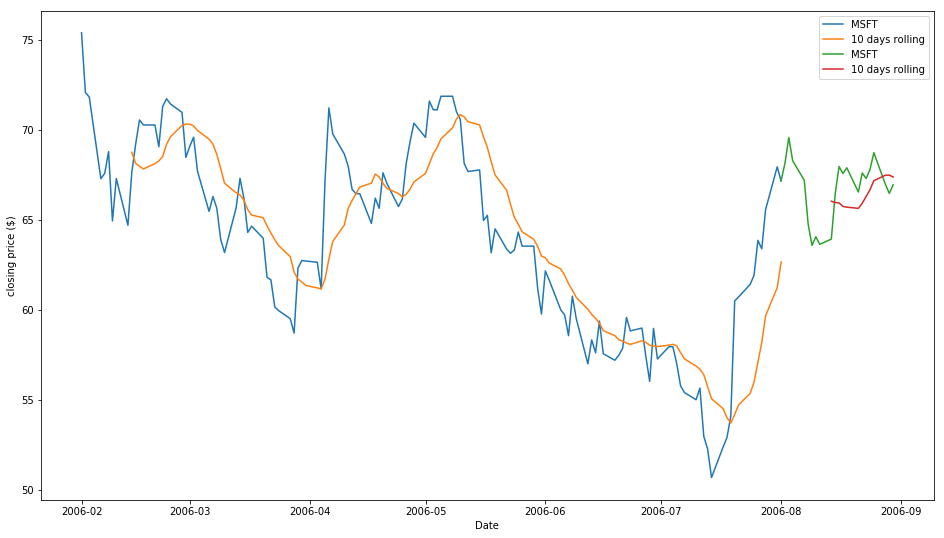

In [0]:
#end another use
fig,ax = plot_rolling_mean(apple_data,"2006-2-01","2006-8-01")
fig,ax = plot_rolling_mean(papple_data,"2006-8-01","2006-8-30",fig,ax)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


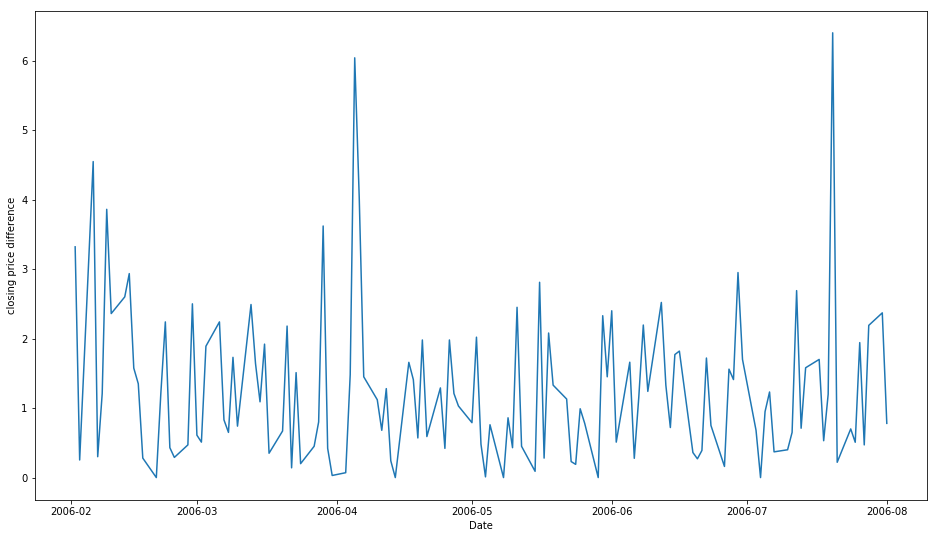

In [0]:
def plot_difference(dataframe,start,end,fig=None,ax=None):  
  close = dataframe['Close']

  all_weekdays = pd.date_range(start=start,end=end, freq='B')

  close = close.reindex(all_weekdays)
  close = close.fillna(method='ffill')
  
  #do all the same as above but this time use our own custom funcation

  def abs_dif(x):
    ret = 0
    for i in range(len(x)-1):
      ret += abs(x[i] - x[i+1])
    return ret
  
  if not fig:
    fig, ax = plt.subplots(figsize=(16,9))

  short_rolling_msft = close.rolling(window=2).apply(abs_dif)

  ax.plot(close.index, short_rolling_msft, label='price diff')

  ax.set_xlabel('Date')
  ax.set_ylabel('closing price difference')
  return fig,ax


fig,ax = plot_difference(apple_data,"2006-2-01","2006-8-01")
fig.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


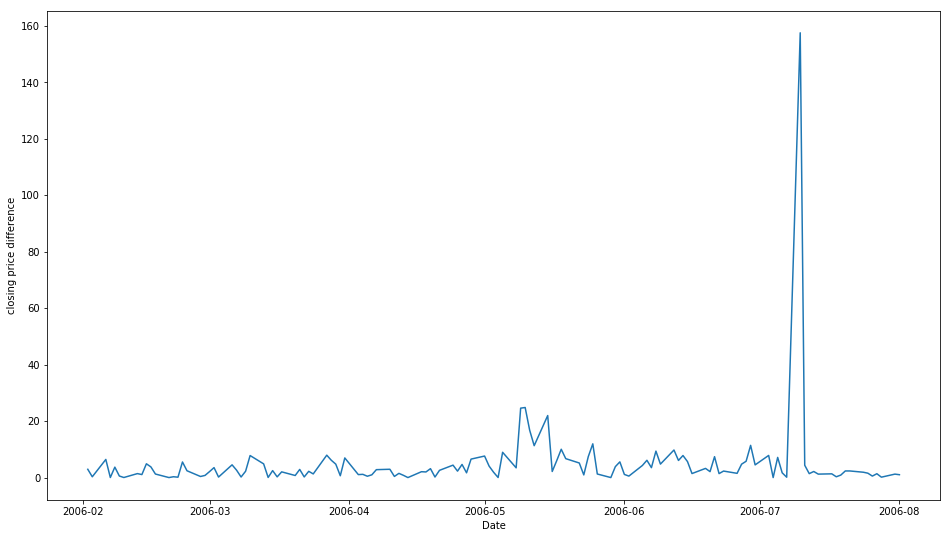

In [0]:
fig,ax = plot_difference(monster_data,"2006-2-01","2006-8-01")
fig.show()

In [0]:
#what happens if we just put the data in a model?
xpoints = np.array(monster_data['Close'])
ypoints = np.array(pmonster_data['Close'])

xpoints = xpoints.reshape(1,xpoints.shape[0])
ypoints = ypoints.reshape(1,ypoints.shape[0])

#we'll try and predict the minecraft data
xtest = np.array(apple_data['Close'])
ytest = np.array(papple_data['Close'])

xtest = xtest.reshape(1,xtest.shape[0])
ytest = ytest.reshape(1,ytest.shape[0])

#we'll be using an elastic net as they're a good general model
estimator = ElasticNet(random_state=0)

estimator.fit(xpoints, ypoints) #expects as [n_samples, n_features]
predictions = estimator.predict(xtest)

mse = mean_squared_error(ytest, predictions)
print(mse)

nan
1227.7691352727272


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


(116, 10)
(116, 1)
0.9824179618434253
28.08546963086729


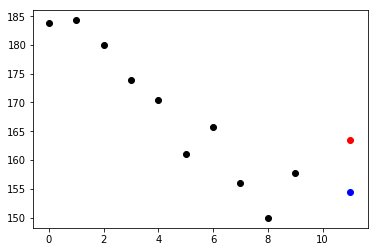

In [0]:
X = np.array(monster_data['Close'])
xpoints = []
ypoints = []
#lets condier out feature as the 10 days before hand
for i in range(10,len(X)):
  #take the ten days beforehand
  xpoints.append(X[i-10:i])
  #take the day we want to predict
  ypoints.append(np.array(X[i]))
#put out data into the right shape
xpoints = np.array(xpoints)
print(xpoints.shape)
ypoints = np.array(ypoints)
ypoints = ypoints.reshape(ypoints.shape[0],1)
print(ypoints.shape)
#split our data randomly into two sets
x_train, x_test, y_train, y_test = train_test_split(xpoints, ypoints, test_size=0.25, random_state=42)
#retrain our model again
estimator = ElasticNet(random_state=0)
estimator.fit(x_train, y_train) #expects as [n_samples, n_features]
predictions = estimator.predict(x_test)
#we'll use r^2 and mse to  evulate our model
coefficient_of_dermination = r2_score(y_test, predictions)
print(coefficient_of_dermination)
mse = mean_squared_error(y_test, predictions)
print(mse)
#lets just see what some of our results are
plt.scatter(np.arange(10), x_test[0],  color='black')
plt.scatter(11, predictions[0], color='blue')
plt.scatter(11, y_test[0], color='red')

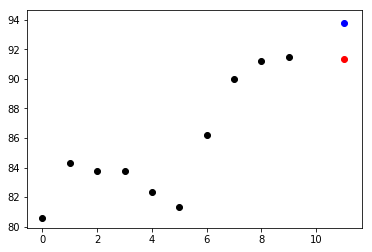

In [0]:
plt.scatter(np.arange(10), x_test[1],  color='black')
plt.scatter(11, predictions[1], color='blue')
plt.scatter(11, y_test[1], color='red')

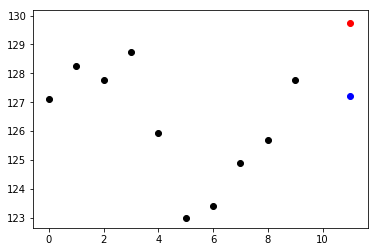

In [0]:
plt.scatter(np.arange(10), x_test[2],  color='black')
plt.scatter(11, predictions[2], color='blue')
plt.scatter(11, y_test[2], color='red')

-115.6409960464006
3568.2520548819757


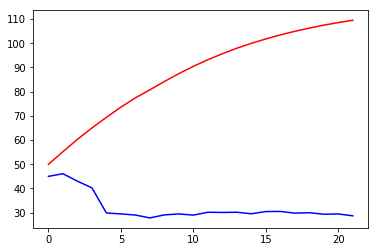

In [0]:
X = list(np.array(monster_data['Close']))
Y = np.array(pmonster_data['Close'])
#lets true and recreate the net 22 days of data with our model

for i in range(22):
  X.append(estimator.predict(np.array(X[-10:]).reshape(1, -1)))
pred = X[-22:]
coefficient_of_dermination = r2_score(Y, pred)
print(coefficient_of_dermination)
mse = mean_squared_error(Y, pred)
print(mse)
plt.plot(pred, color = "red")
plt.plot(Y,color ="blue")
#sadly it's not very good 

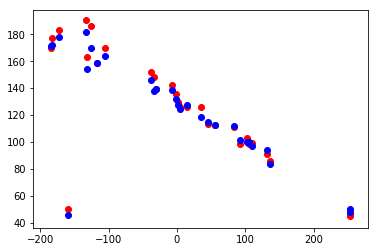

In [0]:
pca = PCA(n_components=1)
#pca take our x data from points to to n_components points
#this allows us to finally plot our results
H = pca.fit_transform(x_train)
plt.scatter(H, y_test, color='red')
plt.scatter(H, predictions, color='blue')

(116, 2)
(116, 1)
0.7034414598096563
473.72129443227766


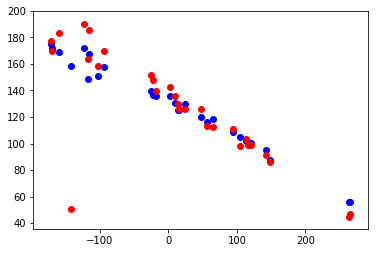

In [0]:
#what if we train our model on this new small x data?
X = np.array(monster_data['Close'])
xpoints = []
ypoints = []
for i in range(10,len(X)):
  xpoints.append(X[i-10:i])
  ypoints.append(np.array(X[i]))
xpoints = np.array(xpoints)
pca = PCA(n_components=2)
xpoints = pca.fit_transform(xpoints)
print(xpoints.shape)
ypoints = np.array(ypoints)
ypoints = ypoints.reshape(ypoints.shape[0],1)
print(ypoints.shape)
x_train, x_test, y_train, y_test = train_test_split(xpoints, ypoints, test_size=0.25, random_state=42)

estimator = ElasticNet(random_state=0)
estimator.fit(x_train, y_train)
predictions = estimator.predict(x_test)

#it's not as good but no by much
coefficient_of_dermination = r2_score(y_test, predictions)
print(coefficient_of_dermination)
mse = mean_squared_error(y_test, predictions)
print(mse)
plt.scatter(x_test[:,0], predictions, color='blue')
plt.scatter(x_test[:,0], y_test, color='red')

-152.44457564457278
4694.137918167544


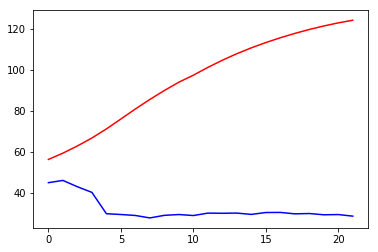

In [0]:
X = list(np.array(monster_data['Close']))
Y = np.array(pmonster_data['Close'])

for i in range(22):
  X.append(estimator.predict(pca.transform(np.array(X[-10:]).reshape(1, -1))))
  
#however does proform a little better on the next 22 days
  
pred = X[-22:]
coefficient_of_dermination = r2_score(Y, pred)
print(coefficient_of_dermination)
mse = mean_squared_error(Y, pred)
print(mse)
plt.plot(pred, color = "red")
plt.plot(Y,color ="blue")

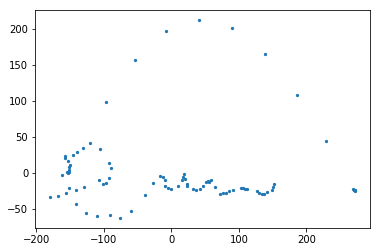

In [0]:
#but what are these PCAs?
#we can plot them and the reults are interesting

pca = PCA(n_components=2)
H = pca.fit_transform(x_train)
plt.scatter(H[:,0],H[:,1],s=5)

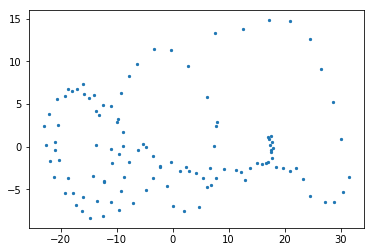

In [0]:
#very intresting
pca = PCA(n_components=2)
X = np.array(apple_data['Close'])
xpoints = []
for i in range(10,len(X)):
  xpoints.append(X[i-10:i])
xpoints = np.array(xpoints)
H = pca.fit_transform(xpoints)
plt.scatter(H[:,0],H[:,1],s=5)

(348, 2)
(348, 1)
0.9826892543930396
44.97534234268821


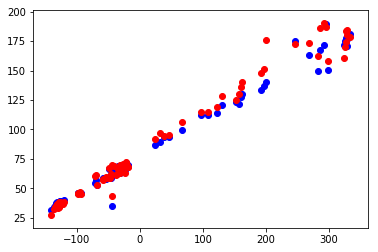

In [0]:
#what if we just add more data?
#alomst always a good idea
X = np.array(monster_data['Close'])
xpoints = []
ypoints = []
for i in range(10,len(X)):
  xpoints.append(X[i-10:i])
  ypoints.append(np.array(X[i]))
X = np.array(apple_data['Close'])
for i in range(10,len(X)):
  xpoints.append(X[i-10:i])
  ypoints.append(np.array(X[i]))
X = np.array(amanoz_data['Close'])
for i in range(10,len(X)):
  xpoints.append(X[i-10:i])
  ypoints.append(np.array(X[i]))

pca = PCA(n_components=2)
xpoints = pca.fit_transform(xpoints)
print(xpoints.shape)
ypoints = np.array(ypoints)
ypoints = ypoints.reshape(ypoints.shape[0],1)
print(ypoints.shape)
x_train, x_test, y_train, y_test = train_test_split(xpoints, ypoints, test_size=0.25, random_state=42)

estimator = ElasticNet(random_state=0)
estimator.fit(x_train, y_train)
predictions = estimator.predict(x_test)


coefficient_of_dermination = r2_score(y_test, predictions)
print(coefficient_of_dermination)
mse = mean_squared_error(y_test, predictions)
print(mse)
plt.scatter(x_test[:,0], predictions, color='blue')
plt.scatter(x_test[:,0], y_test, color='red')

-11.314088218706342
376.709493915135


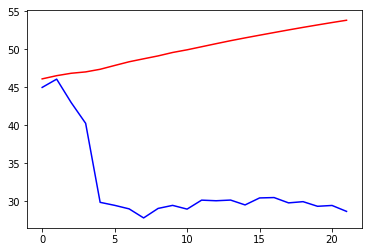

In [0]:
#much better overall
X = list(np.array(monster_data['Close']))
Y = np.array(pmonster_data['Close'])

for i in range(22):
  X.append(estimator.predict(pca.transform(np.array(X[-10:]).reshape(1, -1))))
  
pred = X[-22:]
coefficient_of_dermination = r2_score(Y, pred)
print(coefficient_of_dermination)
mse = mean_squared_error(Y, pred)
print(mse)
plt.plot(pred, color = "red")
plt.plot(Y,color ="blue")

(116, 2)
(116, 1)
Epoch 1/500
87/87 [==============================] - 1s 7ms/step - loss: 18655.7461 - acc: 0.0000e+00
Epoch 2/500
87/87 [==============================] - 0s 37us/step - loss: 9656761057280.0000 - acc: 0.0000e+00
Epoch 3/500
87/87 [==============================] - 0s 34us/step - loss: 19108.2910 - acc: 0.0000e+00
Epoch 4/500
87/87 [==============================] - 0s 33us/step - loss: 19108.2910 - acc: 0.0000e+00
Epoch 5/500
87/87 [==============================] - 0s 29us/step - loss: 19108.2910 - acc: 0.0000e+00
Epoch 6/500
87/87 [==============================] - 0s 25us/step - loss: 19108.2930 - acc: 0.0000e+00
Epoch 7/500
87/87 [==============================] - 0s 24us/step - loss: 19108.2910 - acc: 0.0000e+00
Epoch 8/500
87/87 [==============================] - 0s 27us/step - loss: 19108.2910 - acc: 0.0000e+00
Epoch 9/500
87/87 [==============================] - 0s 25us/step - loss: 19108.2910 - acc: 0.0000e+00
Epoch 10/500
87/87 [============================

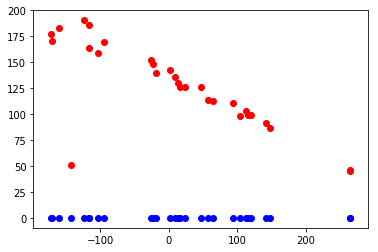

In [0]:
#what with we do machine learning?
X = np.array(monster_data['Close'])
xpoints = []
ypoints = []
for i in range(10,len(X)):
  xpoints.append(X[i-10:i])
  ypoints.append(np.array(X[i]))
xpoints = np.array(xpoints)
pca = PCA(n_components=2)
xpoints = pca.fit_transform(xpoints)
print(xpoints.shape)
ypoints = np.array(ypoints)
ypoints = ypoints.reshape(ypoints.shape[0],1)
print(ypoints.shape)
x_train, x_test, y_train, y_test = train_test_split(xpoints, ypoints, test_size=0.25, random_state=42)

model = keras.models.Sequential()
model.add(keras.layers.Dense(10, activation='relu',input_shape = (2,)))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(1, activation='relu'))
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(lr=10),
              metrics=['accuracy'])
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
history = AccuracyHistory()
model.fit(x_train,y_train,
          batch_size=258,
          epochs=500,
          verbose=1,
          callbacks=[history])


predictions = model.predict(x_test)

#turns out machine learning isn't always the best idea
coefficient_of_dermination = r2_score(y_test, predictions)
print(coefficient_of_dermination)
mse = mean_squared_error(y_test, predictions)
print(mse)
plt.scatter(x_test[:,0], predictions, color='blue')
plt.scatter(x_test[:,0], y_test, color='red')